In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
from pathos.multiprocessing import ProcessPool
import errno
import dill
import sys
sys.path.append('../')

import neat
from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net

import itertools as it
import time
import imageio

import sgr_main as sgr
from matplotlib import pyplot as plt


from substrates import morph_substrate, control_substrate
from generate_robot import generate_robot

In [2]:
def get_robot(genome, params, neat_config):
    cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)

    design_substrate = morph_substrate(params)
    design_net = create_phenotype_network(cppn, design_substrate)

    robot = generate_robot(design_net, params)
    if not sgr.eval_genome_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    env = evogym.envs.gym.make(params["env"], body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [11]:
ENV = "Walker-v0" # env_names = ["CaveCrawler-v0", "UpStepper-v0", "ObstacleTraverser-v1"]
STEPS = 600
ROBOT_SIZE = 5
POP = 128

directory = "results/" + ENV

file = "run_altSpec_1_population.pkl"
defaultGen = neat.DefaultGenome
f = lambda self, other, config: new_distance(params, morph_substrate(params), generate_robot, self, other, config)
defaultGen.distance = f
params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "AA"}
neat_config = neat.config.Config(
    defaultGen,
    neat.reproduction.DefaultReproduction, 
    neat.species.DefaultSpeciesSet, 
    neat.stagnation.DefaultStagnation, 
    "../configs/hyperNEAT_config"
)

# file = "run_CPPN_1_population.pkl"
# params = {"robot_size": ROBOT_SIZE, "env": ENV, "steps": STEPS, "pop_size": POP, "robot_substrate": "CPPN"}
# neat_config = neat.config.Config(
#     neat.genome.DefaultGenome, 
#     neat.reproduction.DefaultReproduction, 
#     neat.species.DefaultSpeciesSet, 
#     neat.stagnation.DefaultStagnation, 
#     "../configs/hyperNEAT_config_CPPN_robot"
# )

with open(f"../{directory}/{file}", "rb") as file:
    pop = dill.load(file)
champion = pop.best_genome
print(champion.fitness)

FileNotFoundError: [Errno 2] No such file or directory: '../results/Walker-v0/run_altSpec_1_population.pkl'

!!!!!!!!!!!!!!!!!!!!!!!! Specie  8 !!!!!!!!!!!!!!!!!!!!!!!!!!!
15555 6.301074687388408


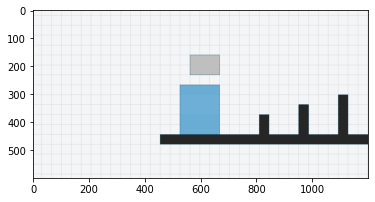

26302 1.651966839249999


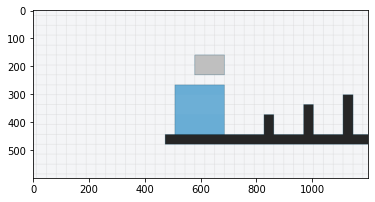

26303 1.6441046955665088


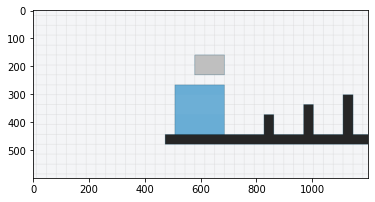

26305 2.808988413728873


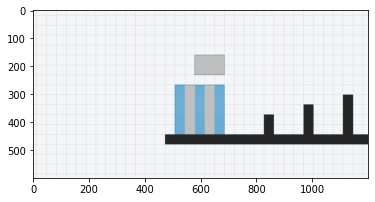

26307 1.6522684842684066


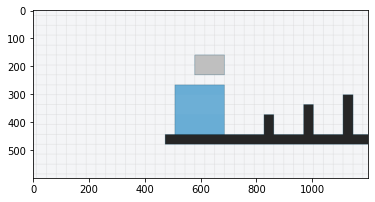

26308 1.6660789987725773


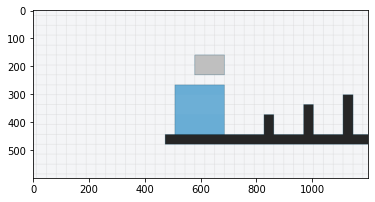

26310 1.6554499137566885


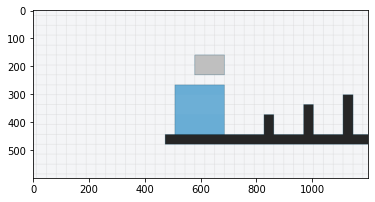

26313 2.9726156884392085


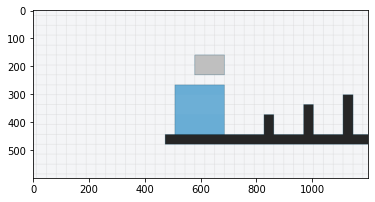

26317 1.6101897298337822


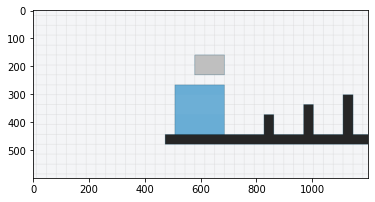

26319 1.1490373063971735


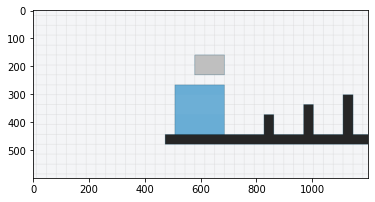

26320 1.6563957789719583


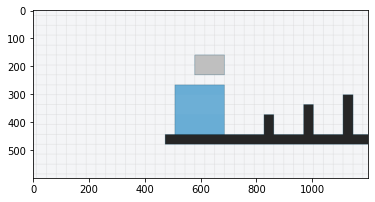

26321 0.8551928608083605


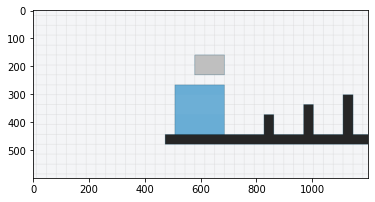

26324 0.32273386874013443


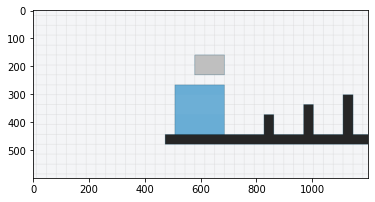

26325 1.236531006144318


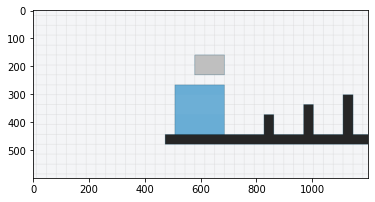

14847 6.036377320809004


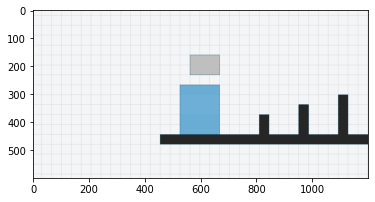

!!!!!!!!!!!!!!!!!!!!!!!! Specie  6 !!!!!!!!!!!!!!!!!!!!!!!!!!!
19227 6.3039570525602056


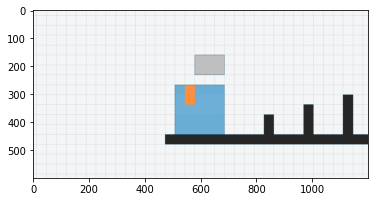

KeyboardInterrupt: 

In [9]:
for k, v in pop.species.species.items():
    print("!!!!!!!!!!!!!!!!!!!!!!!! Specie ", k, "!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    for g in v.members.values():
        if g.fitness != None and g.fitness > .3:
            r, img = get_robot(g, params, neat_config)
            if img is not None:
                print(g.key, g.fitness)
                plt.imshow(img)
                plt.show()

In [10]:
g = champion
# g = pop.population[4778]
sgr.single_genome_fit(g, params, neat_config, True)

(6.389052665105292, True)